<a href="https://colab.research.google.com/github/ngoax/cvdl/blob/main/cvdl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
msambare_fer2013_path = kagglehub.dataset_download('msambare/fer2013')

print('Import of FER2013 complete')

Import of FER2013 complete


In [3]:
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-m66sa3eo
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-m66sa3eo
  Resolved https://github.com/albumentations-team/albumentations to commit 6292ce00a47f9fc39bd8ecf9e970074ff4cfc173
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.24
    Uninstalling albucore-0.0.24:
      Successfully uninstalled albucore-0.0.24
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires albucore==0.0.24, but you have albucore 0.0.28 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00

In [4]:
TRAIN_IMG_FOLDER_PATH = "../kaggle/input/fer2013/train"
VALID_IMG_FOLDER_PATH = "../kaggle/input/fer2013/test"

LR = 0.001
BATCH_SIZE = 32
EPOCHS = 15

DEVICE = 'cuda'
MODEL_NAME = 'efficientnet_b0'

In [12]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
import random
import matplotlib.pyplot as plt

In [6]:
train_augs = T.Compose([
    T.RandomHorizontalFlip(p = 0.5),
    T.RandomRotation(degrees=(-20, + 20)),
    T.ToTensor() # Convert a PIL image or numpy.ndarray to tensor (h, w, c) --> (c, h, w)
])

valid_augs = T.Compose([
    T.ToTensor()
])

In [7]:
trainset = ImageFolder(TRAIN_IMG_FOLDER_PATH, transform = train_augs)
validset = ImageFolder(VALID_IMG_FOLDER_PATH, transform = valid_augs)

In [8]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28709
Total no. of examples in validset : 7178


In [9]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Text(0.5, 1.0, 'happy')

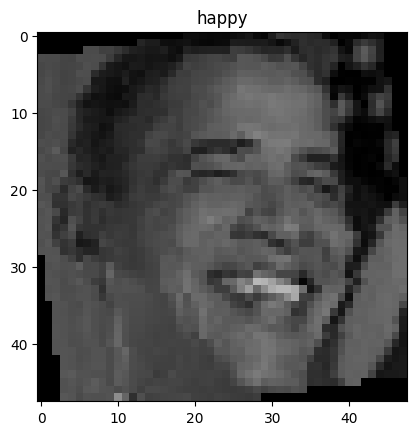

In [23]:
class_names = trainset.classes

index = random.randint(0, len(trainset)-1)
image, label = trainset[index]

plt.imshow(image.permute(1, 2, 0)) # (h, w, c)
plt.title(class_names[label])

Text(0.5, 1.0, 'happy')

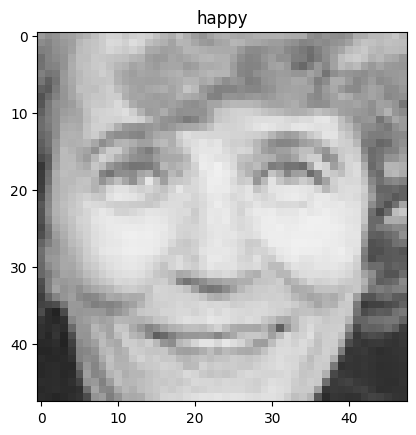

In [26]:
class_names = validset.classes

index = random.randint(0, len(validset)-1)
image, label = validset[index]

plt.imshow(image.permute(1, 2, 0)) # (h, w, c)
plt.title(class_names[label])

## Load Dataset into Batches

In [27]:
from torch.utils.data import DataLoader

In [28]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [32]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 898
Total no. of batches in validloader : 225


In [33]:
for images, labels in trainloader:
    break;

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


## Create Model

In [34]:
import timm
from torch import nn

In [35]:
class FaceModel(nn.Module):

    def __init__(self):
        super(FaceModel, self).__init__()

        self.eff_net = timm.create_model('efficientnet_b0',
                                        pretrained = True,
                                        num_classes = 7)

    def forward(self, images, labels = None):
        logits = self.eff_net(images)

        if labels != None:
            loss = nn.CrossEntropyLoss()(logits, labels)
            return logits, loss

        return logits

In [41]:
model = FaceModel()
model.to(DEVICE)

FaceModel(
  (eff_net): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv

# Create Train and Eval Function

In [37]:
from tqdm import tqdm

In [38]:
def multiclass_accuracy(y_pred, y_true):
    top_p, top_class = y_pred.topk(1, dim = 1)
    equals = top_class = y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [39]:
def train_fn(model, dataloader, optimizer, current_epo):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    tk = tqdm(dataloader, desc = "EPOCH" + "[TRAIN]" + str(current_epo + 1) + "/" + str(EPOCHS))

    for t, data in enumerate(tk):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits, labels)
        tk.set_postfix({'loss' : '%6f' %float(total_loss / (t+1)), 'acc' : '%6f' %float(total_acc / (t+1)),})

    return total_loss / len(dataloader), total_acc / len(dataloader)


In [40]:
def eval_fn(model, dataloader, current_epo):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    tk = tqdm(dataloader, desc = "EPOCH" + "[TRAIN]" + str(current_epo + 1) + "/" + str(EPOCHS))

    for t, data in enumerate(tk):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        logits, loss = model(images, labels)

        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits, labels)
        tk.set_postfix({'loss' : '%6f' %float(total_loss / (t+1)), 'acc' : '%6f' %float(total_acc / (t+1)),})

    return total_loss / len(dataloader), total_acc / len(dataloader)


# Create Training Loop

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = LR)

In [48]:
best_valid_loss = np.inf

for i in range(EPOCHS):
    train_loss, train_acc = train_fn(model, trainloader, optimizer, i)
    valid_loss, valid_acc = eval_fn(model, validloader, i)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best-weights.pt')
        print("SAVED-BEST-WEIGHTS")
        best_valid_loss = valid_loss

EPOCH[TRAIN]1/15: 100%|██████████| 225/225 [00:32<00:00,  6.91it/s, loss=1.338002, acc=3.300833]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]2/15: 100%|██████████| 225/225 [00:10<00:00, 22.05it/s, loss=1.218099, acc=3.300833]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]3/15: 100%|██████████| 225/225 [00:10<00:00, 22.31it/s, loss=1.128520, acc=3.300833]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]4/15: 100%|██████████| 225/225 [00:09<00:00, 22.64it/s, loss=1.075299, acc=3.300833]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]6/15: 100%|██████████| 225/225 [00:10<00:00, 21.79it/s, loss=1.038056, acc=3.300833]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]8/15: 100%|██████████| 225/225 [00:10<00:00, 22.50it/s, loss=1.028182, acc=3.300833]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]9/15: 100%|██████████| 225/225 [00:09<00:00, 22.61it/s, loss=1.005805, acc=3.300833]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]13/15: 100%|██████████| 225/225 [00:09<00:00, 22.77it/s, loss=1.000235, acc=3.300833]


SAVED-BEST-WEIGHTS


EPOCH[TRAIN]15/15: 100%|██████████| 225/225 [00:10<00:00, 22.04it/s, loss=0.995928, acc=3.300833]


SAVED-BEST-WEIGHTS


# Inference

In [49]:
def view_classify(img, ps):

    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'suprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)

    fig, (ax1, ax2) = plt.subplots(figsize = (5,9), ncols = 2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

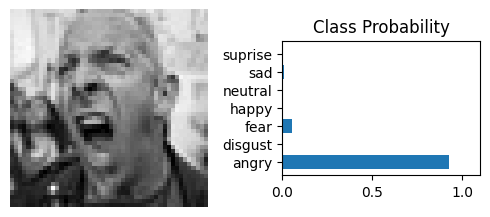

In [53]:
image, label = validset[7]
image = image.unsqueeze(0)

logits = model(image.to(DEVICE))
probs = nn.Softmax(dim=1)(logits)

view_classify(image.squeeze(), probs)